Импортируем бмблиотеки

In [1]:
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

Загрузка данных

In [4]:
X_bp = pd.read_csv("X_bp.csv", index_col=0)  # первый датасет
X_nup = pd.read_csv("X_nup.csv", index_col=0)  # второй датасет
data = X_bp.join(X_nup, how="inner")

Убираем выбросы (IQR)

In [5]:
# Рассчитываем IQR для каждого признака
Q1 = data.quantile(0.1)
Q3 = data.quantile(0.9)
IQR = Q3 - Q1
# Вычисляем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Убираем выбросы
data = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]

Корреляция между признаками

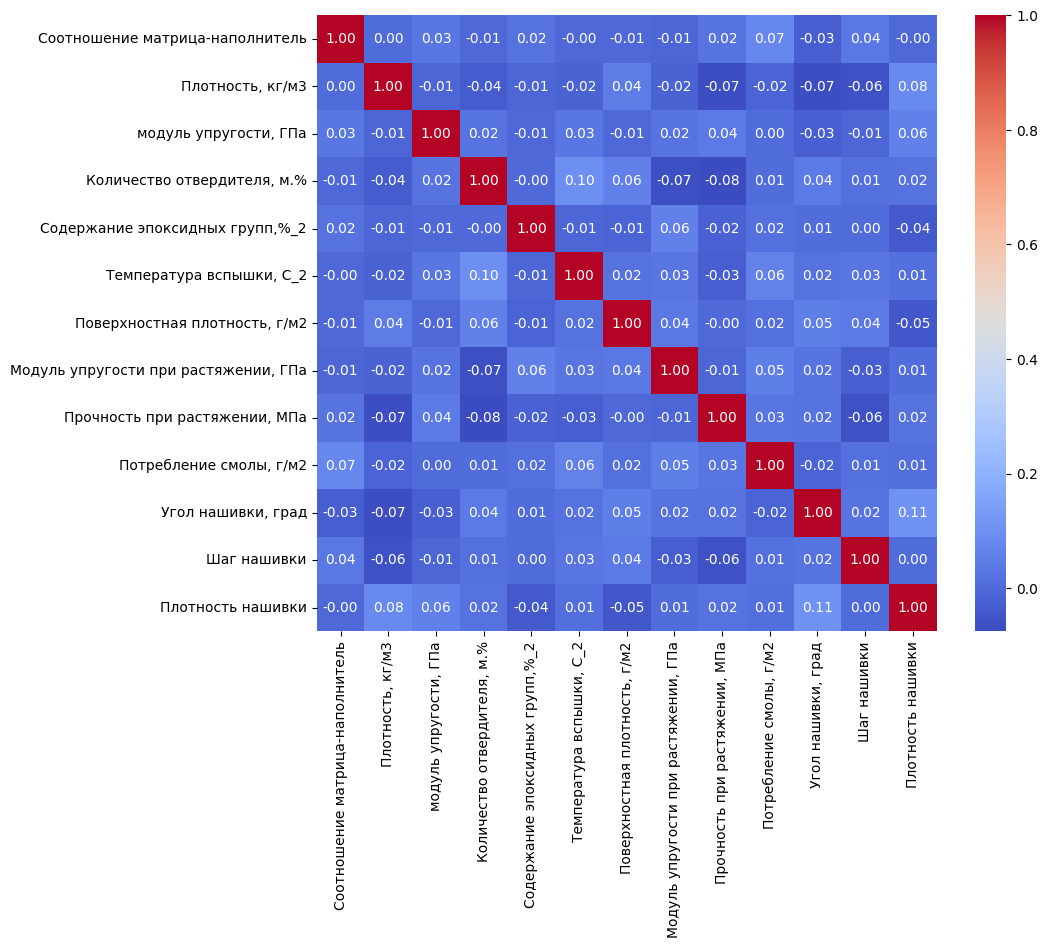

In [6]:
# Вычисляем корреляцию между признаками
corr_matrix = data.corr()
# Строим тепловую карту для наглядности
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Разделяем выборки

In [7]:
# определим целевую переменную (target) и признаки (все кроме целевой)
X = data.drop(columns=['Соотношение матрица-наполнитель', "Плотность, кг/м3", "Плотность нашивки"])
y = data['Соотношение матрица-наполнитель']

Масштабирование признаков

In [8]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Разделение данных на обучающую и тестовую выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Создание модели

In [18]:
model = Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1],))) # входной слой (слой для признаков)
model.add(Dense(128, activation='tanh')) # скрытый слой
model.add(Dense(64, activation='tanh')) # скрытый слой
model.add(Dense(32, activation='tanh')) # скрытый слой
model.add(Dense(1)) # выходной слой (для прогнозирования соотношения)

Компиляция модели

In [19]:
model.compile(optimizer='rmsprop', loss='mean_squared_error')

Обучение модели

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8119 - val_loss: 0.9571
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8466 - val_loss: 0.9165
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8794 - val_loss: 0.9336
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8492 - val_loss: 1.0100
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8491 - val_loss: 0.9058
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7983 - val_loss: 0.9189
Epoch 7/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8863 - val_loss: 0.9455
Epoch 8/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7813 - val_loss: 0.9294
Epoch 9/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8416 - val_loss: 0.9082
Epoch 10/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8264 - val_loss: 0.9109
Epoch 11/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8436 - val_loss: 0.9347
Epoch 12/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/st

Оценка модели на тестовых данных

In [21]:
test_loss = model.evaluate(X_test, y_test)
print(f'Loss on test data: {test_loss}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8333 
Loss on test data: 0.8826087117195129


Проведение собственных тестов

In [22]:
new_data = [
    [738.7368421, 30, 22.26785714, 100, 210, 70, 3000, 220, 0, 4],
    [506, 129, 21.25, 300, 380, 75, 1800, 120, 0, 10],
    [478.2862473, 105.7869296, 17.87409991, 328.1545795, 526.6921594, 72.34570879, 3059.032991, 275.5758795, 90, 5],
    [641.0525494, 96.56329319, 22.98929056, 262.956722, 804.5926208, 74.51135922, 2288.967377, 126.8163389, 90, 7],
]
new_data_scaled = scaler.transform(new_data)
predicted_ratio = model.predict(new_data_scaled)
print(predicted_ratio)
print(f'Предсказанное соотношение матрица-наполнитель:')
print(1.8571429 ,predicted_ratio[0][0])
print(4.193548387, predicted_ratio[1][0])
print(3.305535422, predicted_ratio[2][0])
print(2.709554095, predicted_ratio[3][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
[[2.6902726]
 [3.0597205]
 [2.9619231]
 [2.8624492]]
Предсказанное соотношение матрица-наполнитель:
1.8571429 2.6902726
4.193548387 3.0597205
3.305535422 2.9619231
2.709554095 2.8624492


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Ошибки при обучении и тестировании

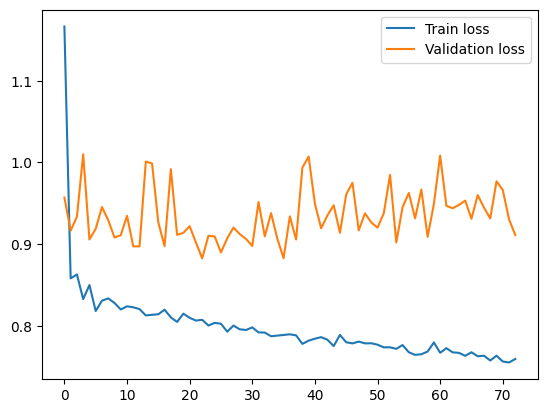

In [23]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.savefig("neiro_error.png")

Оценка показателей (r^2, mse, mae, mape)

In [27]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R2 Score: 0.013955117927451521
MSE: 0.882608688350716
MAE: 0.7778307580864241
MAPE: 0.31640943716505177


Сравнение реальных и предсказанных значений

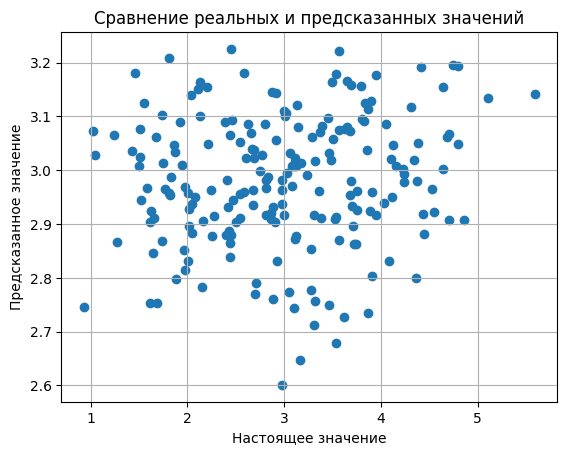

In [28]:
plt.scatter(y_test, y_pred)
plt.xlabel('Настоящее значение')
plt.ylabel('Предсказанное значение')
plt.title('Сравнение реальных и предсказанных значений')
plt.grid()
plt.show()

Сохранение модели

In [29]:
model.save('neiro_model.h5')
joblib.dump(scaler, 'neiro_scaler.pkl')

['neiro_scaler.pkl']